## Fit TCN

In [1]:
# pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple -r requirements.txt --use-deprecated=legacy-resolver
# pip install s3fs
# !pip install sidetable


In [2]:
import sys, os, json
import torch
import pandas as pd
import numpy as np
import rdsutils.datagen as datagen
import matplotlib.pyplot as plt
import sidetable
from sklearn.metrics import roc_auc_score
from smart_open import open
import pickle as pkl

# sys.path.insert(1, "/home/ec2-user/SageMaker/projects-framework/sequential-models/TCN_v2")
# sys.path.insert(1, "../..")

%load_ext autoreload
%autoreload 2

from utils import preprocess, features

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn")

In [3]:
s3_path = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/with-tcn/"

static_features = features
dynamic_features = ['nr_past_transactions', 'card_present_ind', 
                'hr_of_transaction', 'transaction_code',
                'transaction_as_pct_of_balance', 'transaction_amount']
stnry_features = ['all7120', 'vantage_score', 'mtf5820', 'fico_score', 'fraud_score_1', 
                  'iln5520', 'bcc7120', 'phone_risk_score', 'email_risk_score', 'address_risk_score', 
                  'stu5031', 'bcx3423', 'fraud_score_2', 'iqt9415']
target_col=['target']
meta_cols=['borrower_id', 'sample_date', 'transaction_datetime']

static_cols = static_features + target_col + meta_cols + ["indeterminate"]
dynamic_cols = dynamic_features + stnry_features + target_col + meta_cols

cat_cols = ['transaction_code', 'transaction_code_encoded', 
            'all7120_default_encoded', 'bcc7120_default_encoded']


In [4]:
%%time

debug = True

if debug:
    train_static = pd.read_parquet(os.path.join(s3_path, "debug_train_static.parquet"))
    train_dynamic = pd.read_parquet(os.path.join(s3_path, "debug_train_dynamic.parquet"))

    test_static = pd.read_parquet(os.path.join(s3_path, "debug_test_static.parquet"))
    test_dynamic = pd.read_parquet(os.path.join(s3_path, "debug_test_dynamic.parquet"))
else:
    train_static = pd.read_parquet(os.path.join(s3_path, "train_static.parquet"))
    train_dynamic = pd.read_parquet(os.path.join(s3_path, "train_dynamic.parquet"))

    test_static = pd.read_parquet(os.path.join(s3_path, "test_static.parquet"))
    test_dynamic = pd.read_parquet(os.path.join(s3_path, "test_dynamic.parquet"))

CPU times: user 614 ms, sys: 118 ms, total: 733 ms
Wall time: 1.56 s


In [5]:
train_dynamic = train_dynamic[~train_dynamic.target.isna()]
test_dynamic = test_dynamic[~test_dynamic.target.isna()]

### Fillna and clipping


In [6]:
cols = ['nr_past_transactions', 'card_present_ind', 
        'hr_of_transaction', 'transaction_as_pct_of_balance',
        'transaction_amount']

for c in cols:
    train_dynamic[c] = train_dynamic[c].astype(float)
    test_dynamic[c] = test_dynamic[c].astype(float)

In [7]:
%%time 
missing_tbl = train_dynamic[dynamic_features + stnry_features].stb.missing()
missing_tbl[missing_tbl.missing > 0]
na_values = dict(zip(missing_tbl.index, [-1.0 for i in range(len(missing_tbl))]))
for c in cat_cols:
    if c in na_values:
        del na_values[c]
train_dynamic.fillna(na_values, inplace=True)

CPU times: user 20.9 ms, sys: 1.82 ms, total: 22.8 ms
Wall time: 21.9 ms


In [8]:
%%time 
missing_tbl = test_dynamic[dynamic_features + stnry_features].stb.missing()
missing_tbl[missing_tbl.missing > 0]
na_values = dict(zip(missing_tbl.index, [-1.0 for i in range(len(missing_tbl))]))
for c in cat_cols:
    if c in na_values:
        del na_values[c]
test_dynamic.fillna(na_values, inplace=True)

CPU times: user 15.4 ms, sys: 3.6 ms, total: 19 ms
Wall time: 18.7 ms


In [9]:
train_dynamic.all7120.clip(upper=250, inplace=True)
train_dynamic.bcc7120.clip(upper=200, inplace=True)
train_dynamic.fico_score.clip(upper=900, inplace=True) # naive clipping

test_dynamic.all7120.clip(upper=250, inplace=True)
test_dynamic.bcc7120.clip(upper=200, inplace=True)
test_dynamic.fico_score.clip(upper=900, inplace=True) # naive clipping

### Some Plotting

<AxesSubplot:>

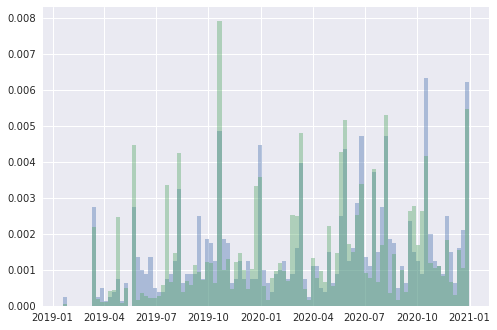

In [10]:
train_static.sample_date.hist(bins=100, alpha=0.4, density=True)
train_dynamic.sample_date.hist(bins=100, alpha=0.4, density=True)

<AxesSubplot:>

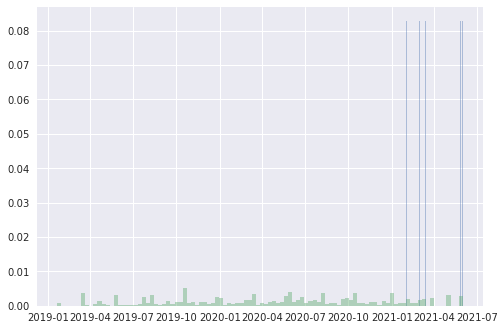

In [11]:
test_static.sample_date.hist(bins=100, alpha=0.4, density=True)
test_dynamic.sample_date.hist(bins=100, alpha=0.4, density=True)

In [12]:
train_dynamic.columns

Index(['nr_past_transactions', 'card_present_ind', 'hr_of_transaction',
       'transaction_code', 'transaction_as_pct_of_balance',
       'transaction_amount', 'all7120', 'vantage_score', 'mtf5820',
       'fico_score', 'fraud_score_1', 'iln5520', 'bcc7120', 'phone_risk_score',
       'email_risk_score', 'address_risk_score', 'stu5031', 'bcx3423',
       'fraud_score_2', 'iqt9415', 'target', 'borrower_id', 'sample_date',
       'transaction_datetime', 'business_account_number'],
      dtype='object')

In [13]:
train_dynamic[cols].stb.missing()

,missing,total,percent
nr_past_transactions,0,20812,0.0
card_present_ind,0,20812,0.0
hr_of_transaction,0,20812,0.0
transaction_as_pct_of_balance,0,20812,0.0
transaction_amount,0,20812,0.0


In [14]:
import src.TCNs as models

feature_embed_dims = {'transaction_code': 20} 
pos_weight = len(train_dynamic) / train_dynamic.target.value_counts().loc[True]

model_dir = "../../../models/tcn-dev"
os.makedirs(model_dir, exist_ok=True)

cols = dynamic_features + stnry_features + target_col + ["transaction_datetime", "business_account_number"]

tcn = models.TCNBinaryClassifier(tcn_layers=[[200, 200], [200, 200], [200, 200]], 
                         mlp_layers=[200, 200, 100], 
                         epoch=10, 
                         kernel_size=[5, 7, 3],
                         batch_size=32, 
                         device="cpu",  #"cuda:0", 
                         dropout_mlp=0.5, 
                         dropout_tcn=0.2, 
                         feature_embed_dims=feature_embed_dims, 
                         patience=10, 
                         model_dir=model_dir,
                         lr=0.0001, 
                         print_freq=300,
                         lr_decay_freq=3, 
                         weight_decay=0,
                         verbose=1,
                         min_length=1,
                         mlp_batch_norm=True)

# for now, group_by only takes one item
# We don't have to process data and test_data again since it was created in the previous block. Only keep here for completeness 
%time data = tcn.process_data(train_dynamic[cols], 'target', test_dynamic[cols], sort_by_col=['transaction_datetime'], group_by=['business_account_number'])
%time test_data = tcn.process_data_inference(test_dynamic[cols], target_col='target', sort_by_col=['transaction_datetime'], group_by=['business_account_number'])
print("\nfitting model")
%time tcn.fit(data)

data processed!
CPU times: user 332 ms, sys: 33.5 ms, total: 366 ms
Wall time: 363 ms
data processed!
CPU times: user 135 ms, sys: 4.35 ms, total: 140 ms
Wall time: 140 ms

fitting model
feature (transaction_code) vocabulary size: 44 
shuffling dataset:  True
num unknown tokens in test set:  0
train loader length: 2

Initializing a new model

saving vocabularies ... 
model_params: {   'device': 'cpu',
    'dropout_mlp': 0.5,
    'dropout_tcn': 0.2,
    'embed_dims': {'transaction_code': 20},
    'features_cat': ['transaction_code'],
    'features_num': [   'address_risk_score',
                        'all7120',
                        'bcc7120',
                        'bcx3423',
                        'card_present_ind',
                        'email_risk_score',
                        'fico_score',
                        'fraud_score_1',
                        'fraud_score_2',
                        'hr_of_transaction',
                        'iln5520',
                      

In [15]:
# # load back the model saved at the early stopping iteration, to cpu
# tcn = torch.load(os.path.join(model_dir, "tcn.pth"), map_location='cpu')

# # process inference dataframe
# %time test_data = tcn.process_data_inference(test_dynamic[cols], target_col='target', sort_by_col=['transaction_datetime'], group_by=['business_account_number'])

# # make predictions. 
# # given a dataframe with multiple sequences, return predictions at all timesteps. 
# preds = tcn.predict_proba(test_data, return_sequences=False)    

# # given a dataframe with multiple sequences, return predictions at the last timestep.
# preds_seq = tcn.predict_proba(test_data, return_sequences=True)

# # # join the preds dataframe with df_test based on the 'index' column
# inference_pred = pd.merge(preds, test_dynamic, on=['transaction_datetime', 'business_account_number'], how='inner')

# # # print the roc_auc score of the model prediction
# print(roc_auc_score(y_true=inference_pred.target.astype(int), y_score=inference_pred.tcn_pred))
# inference_pred.head()

In [16]:
tcn = torch.load(os.path.join(model_dir, "tcn.pth"), map_location='cpu')
# test_data = tcn.process_data_inference(test_dynamic[cols], target_col='target', sort_by_col=['transaction_datetime'], group_by=['business_account_number'])

train_pred = tcn.predict_proba(data, return_sequences=True)
test_pred = tcn.predict_proba(test_data, return_sequences=True)

loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False
loading vocabs....
num unknown tokens in test set:  0
shuffling dataset:  False


In [17]:
for df in [train_static, train_pred, test_static, test_pred]:
    df["business_account_number"] = df["business_account_number"].astype(int)

In [18]:
train_pred.sort_values("transaction_datetime", inplace=True)
test_pred.sort_values("transaction_datetime", inplace=True)
train_static = pd.merge_asof(train_static, train_pred,
                             left_on="sample_date", right_on="transaction_datetime",
                             by="business_account_number", direction="backward",
                             suffixes=("", "_dup"))
test_static = pd.merge_asof(test_static, test_pred,
                             left_on="sample_date", right_on="transaction_datetime",
                             by="business_account_number", direction="backward",
                             suffixes=("", "_dup"))

train_static["tcn_pred"] = train_static["tcn_pred"].astype(float)
test_static["tcn_pred"] = test_static["tcn_pred"].astype(float)

### Fit LGBM

In [41]:
features_w_tcn = features + ["tcn_pred"]
targets = [{'target_col_name': 'target'}]

In [46]:
import lightgbm as lgb

def train(modeling_df, 
          date_col="sample_date", 
          indeterminate_col="indeterminate"):
    """
    Train and save model.
    """
    targ_cols = []
    for t in targets:
        targ_cols.extend(t.values())
    
    other_cols = []
    if indeterminate_col is not None:
        other_cols.append(indeterminate_col)
    if date_col is not None:
        other_cols.append(date_col)
        
    modeling_df = modeling_df[features_w_tcn+targ_cols+other_cols]
    
    if indeterminate_col in modeling_df.columns:
        print("data statistics", modeling_df.shape)
        print("indeterminate removed! column name: ", indeterminate_col)
        modeling_df = modeling_df[~modeling_df[indeterminate_col]]
        print("data statistics after removing indeterminate", modeling_df.shape)
        
    print("we have preprocessed beforehand!!!")
    # modeling_df = preprocess(modeling_df)
    print(f"modeling_df last date: {modeling_df[date_col].max()}")
    

    # model hyper params
    seed = 15556
    print(seed)
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "boosting": 'gbdt',
        "num_iterations": 1400,
        "max_depth" : 4,
        "num_leaves" : 15,
        "learning_rate" : 0.03,
        "feature_fraction" : 0.8,
        "subsample": 0.94,
        "lambda_l1": 16,
        "lambda_l2": 10,
        "min_data_in_leaf": 116,
        "tree_learner": "feature",
        "bagging_seed" : seed,
        "verbosity" : 1,
        "seed": seed,
        "categorical_feature": [39, 40, 41]  # with giact_time_since_last_link [40, 41, 42]
    }
    

    for target_definion in targets:
        target_col_name = target_definion['target_col_name']
        if 'ind_col_name' in target_definion:
            ind_col_name = target_definion['ind_col_name']
        else:
            ind_col_name = None
        
        if ind_col_name:
            mdf = modeling_df[~modeling_df[ind_col_name]]
        else:
            mdf = modeling_df.copy()
            
        print("target counts")
        print(mdf[target_col_name].value_counts())
        
        count_pos = mdf[target_col_name].sum()
        count_neg = (~mdf[target_col_name]).sum()
        pos_wgt_scaling_factor = count_neg / count_pos
        
        params['scale_pos_weight'] = pos_wgt_scaling_factor
        
        X = mdf[features_w_tcn]
        y = mdf[target_col_name]
    
        clf = lgb.LGBMClassifier(**params)
        clf = clf.fit(X, y)
        
    
    return clf


def scale_scores(predictions):
    """
    Convert probability to score.
    """
    try:
        assert (
            (predictions >= 0) & (predictions <= 1)
        ).all(), "probability must be in range [0,1]"
    except AssertionError:
        raise

    # Formula parameters
    ALPHA = 631.9455383610933
    BETA = 30.812519272450654

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(
        np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM),
        MAXIMUM,
    )

    return score


In [43]:
lgbm_tcn = train(train_static,
                 date_col="sample_date",
                 indeterminate_col="indeterminate")

data statistics (1132, 45)
indeterminate removed! column name:  indeterminate
data statistics after removing indeterminate (814, 45)
we have preprocessed beforehand!!!
modeling_df last date: 2020-12-31 00:00:00
15556
target counts
False    737
True      77
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is 

In [53]:
display(lgbm_tcn.feature_name_)
test_static["pred_lgbm_tcn"] = lgbm_tcn.predict_proba(test_static[lgbm_tcn.feature_name_])[:,1]
test_static["score_lgbm_tcn"] = scale_scores(test_static["pred_lgbm_tcn"])

['first_deposit_amount',
 'vantage_score',
 'bcc7120',
 'email_risk_score',
 'fraud_score_2',
 'name_email_correlation',
 'transaction_as_pct_of_balance',
 'mean_account_balance_30d',
 'phone_risk_score',
 'name_address_correlation',
 'all8220',
 'lag_acc_open_first_transaction',
 'dollar_val_dd',
 'all7120',
 'sum_deposits_10d',
 'nr_past_transactions',
 'total_tradelines_open',
 'education_loan_amount',
 'address_risk_score',
 'iqt9415',
 'max_withdrawals_30d',
 'iln5520',
 'max_deposits_30d',
 'pct_returned_deposits',
 'giact_nr_decline',
 'nr_direct_deposits',
 'time_since_last_transaction',
 'bal_ratio',
 'name_phone_correlation',
 'giact_nr_other',
 'dollar_val_returns',
 'nr_trans_ratio',
 'iqt9413',
 'dollar_val_returns_3d',
 'nr_returns_30d',
 'credit_card_loan_amount',
 'fraud_score_1',
 'age_money_account',
 'transaction_code_encoded',
 'all7120_default_encoded',
 'bcc7120_default_encoded',
 'tcn_pred']

In [54]:
import rdsutils.plot as rdsplot

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

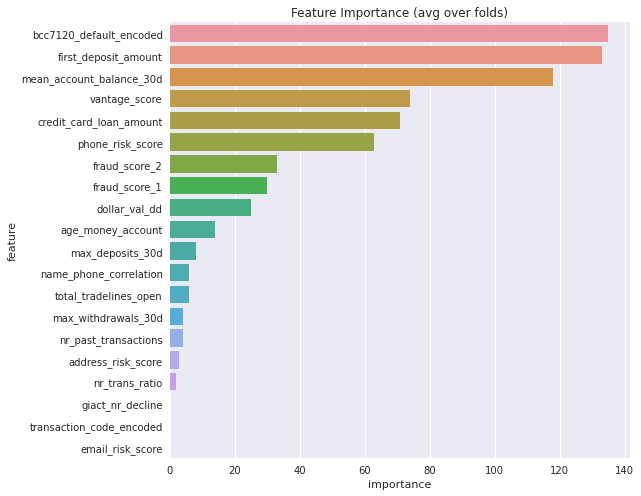

In [56]:
rdsplot.display_feature_importance(lgbm_tcn.feature_name_,
                                   lgbm_tcn.feature_importances_)

### Benchmarking

In [60]:
mpath = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_refit_20201231_wo_ind.pkl"
with open(mpath, "rb") as f:
    incumbent_model = pkl.load(f)

test_static["pred_customer"] = incumbent_model.predict_proba(test_static[incumbent_model.feature_name_])[:,1]
test_static["score_customer"] = scale_scores(test_static["pred_customer"])

(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

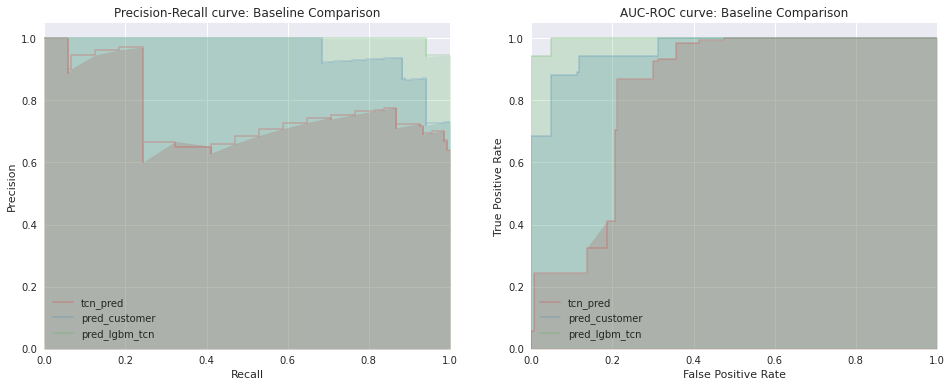

In [62]:
pred_cols = ["tcn_pred", "pred_customer", "pred_lgbm_tcn"]
preds = [(test_static[col], col) for col in pred_cols]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
cmap = plt.get_cmap("Set1")
colors = [cmap(i) for i in range(len(preds))]  # np.linspace(0, 1, len(preds))]

title = "Precision-Recall curve: Baseline Comparison"
rdsplot.plot_pr_curve_mult(
    test_static[target_col], preds, title=title, colors=colors, ax=axs[0], fig=fig
)

title = "AUC-ROC curve: Baseline Comparison"
rdsplot.plot_auc_curve_mult(
    test_static[target_col], preds, title=title, colors=colors, ax=axs[1], fig=fig
)

### OOT scored

In [63]:
%%time
train_static.to_parquet(os.path.join(s3_path, "scored_train_static.parquet"))
train_dynamic.to_parquet(os.path.join(s3_path, "scored_train_dynamic.parquet"))

test_static.to_parquet(os.path.join(s3_path, "scored_test_static.parquet"))
test_dynamic.to_parquet(os.path.join(s3_path, "scored_test_dynamic.parquet"))

CPU times: user 325 ms, sys: 14 ms, total: 339 ms
Wall time: 1.21 s
